In [1]:
import pandas as pd
import numpy as np
from random import sample
from collections import defaultdict
from sklearn import linear_model
import os
from urllib.request import urlopen
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [70]:
header = ['Rk','G','Date','Team','Away','Opp','W/L','PS','PA','FG','FGA','FG%','3P','3PA','3P%','FT','FTA','FT%','ORB','TRB','AST','STL','BLK','TOV','PF','Drop','OFG','OFGA','OFG%','O3P','O3PA','O3P%','OFT','OFTA','OFT%','OORB','OTRB','OAST','OSTL','OBLK','OTOV','OPF']
df = pd.read_csv('Data/gsw.csv')
df.columns = header
df = df[1:]
for file in os.listdir('Data'):
    df_add = pd.read_csv(os.path.join('Data',file))
    df_add.columns = header
    df_add = df_add[1:]
    df = df.append(df_add)
df = df[82:]
df['Away'] = df['Away'].map({'@':1,np.nan:0})

In [71]:
df['Rk'] = df['Rk'].astype(int)
df['W/L'] = df['W/L'].map({'W':1,'L':0})
df = df.drop(columns=['Drop'])

In [72]:
change = ['PS','PA','FG','FGA','FG%','3P','3PA','3P%','FT','FTA','FT%','ORB','TRB','AST','STL','BLK','TOV','PF','OFG','OFGA','OFG%','O3P','O3PA','O3P%','OFT','OFTA','OFT%','OORB','OTRB','OAST','OSTL','OBLK','OTOV','OPF']
for col in change:
    if '.' in df.iloc[0][col]:
        df[col] = df[col].astype(float)
    else:
        df[col] = df[col].astype(int)

In [77]:
elligible = df[df['Rk']>10]

In [79]:
randomized = elligible.sample(frac=1).reset_index(drop=True)

In [81]:
train = randomized[:1512]
valid = randomized[1512:1836]
test = randomized[1836:]

In [83]:
train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

In [163]:
train_y = list(train['W/L'].values)
valid_y = list(valid['W/L'].values)
test_y = list(test['W/L'].values)

In [148]:
stats = ['W/L','PS','PA','FG','FGA','FG%','3P','3PA','3P%','FT','FTA','FT%','ORB','TRB','AST','STL','BLK','TOV','PF','OFG','OFGA','OFG%','O3P','O3PA','O3P%','OFT','OFTA','OFT%','OORB','OTRB','OAST','OSTL','OBLK','OTOV','OPF']
op_cols = ['Opp_W/L','Opp_PS','Opp_PA','Opp_FG','Opp_FGA','Opp_FG%','Opp_3P','Opp_3PA','Opp_3P%','Opp_FT','Opp_FTA','Opp_FT%','Opp_ORB','Opp_TRB','Opp_AST','Opp_STL','Opp_BLK','Opp_TOV','Opp_PF','Opp_OFG','Opp_OFGA','Opp_OFG%','Opp_O3P','Opp_O3PA','Opp_O3P%','Opp_OFT','Opp_OFTA','Opp_OFT%','Opp_OORB','Opp_OTRB','Opp_OAST','Opp_OSTL','Opp_OBLK','Opp_OTOV','Opp_OPF']
def get_averages(data):
    team_data = df[df['Team']==data['Team']]
    opp_data = df[df['Team']==data['Opp']]
    team_data = team_data[team_data['Rk'] < data['Rk']]
    opp_rk = df[df['Date']==data['Date']]
    opp_rk = opp_rk[opp_rk['Team']==data['Opp']]['Rk'].values[0]
    opp_data = opp_data[opp_data['Rk'] < opp_rk]
    team_stats_means = team_data[stats].mean()
    opp_stats_means = opp_data[stats].mean()
    opp_stats_means.index = op_cols
    result_row = data[0:6].append(team_stats_means)
    result_row = result_row.append(opp_stats_means)
    return result_row

In [149]:
averages = []
for i in range(len(train)):
    averages.append(get_averages(train.iloc[i]))

In [152]:
train_transform = pd.concat(averages,axis = 1).transpose()

In [153]:
averages_valid = []
for i in range(len(valid)):
    averages_valid.append(get_averages(valid.iloc[i]))
averages_test = []
for i in range(len(test)):
    averages_test.append(get_averages(test.iloc[i]))
valid_transform = pd.concat(averages_valid,axis = 1).transpose()
test_transform = pd.concat(averages_test,axis = 1).transpose()

In [165]:
valid_transform['W/L'] = valid_y
train_transform['W/L'] = train_y
test_transform['W/L'] = test_y

In [167]:
train_transform.to_csv('train_averages.csv')
valid_transform.to_csv('valid_averages.csv')
test_transform.to_csv('test_averages.csv')

In [232]:
year = 1996
url = 'https://www.basketball-reference.com/teams/NYK/{}/gamelog-advanced/'.format(year)
html = urlopen(url)
soup = BeautifulSoup(html)

In [235]:
drop_indices = [20,21,42,43,64,65,86,87]
[x for x in drop_indices if x < 66]

[20, 21, 42, 43, 64, 65]

In [252]:
all_stats = []
for team in full_teams:
    for year in range(1994,2020):
        url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
        html = urlopen(url)
        soup = BeautifulSoup(html)
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:]
        rows = soup.findAll('tr')[2:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
        stats = pd.DataFrame(player_stats, columns = headers)
        stats['Team'] = team
        stats['Season'] = year
        new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
               'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
               'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
               'Team','Season']
        stats.columns = new_columns
        drop_indices = [20,21,42,43,64,65,86,87]
        drop_indices = [x for x in drop_indices if x < len(stats)]
        stats = stats.drop(columns = ['Drop'],index = drop_indices)
        stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
        stats['Away'] = stats['Away'].fillna(0)
        stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
        all_stats.append(stats)

In [253]:
most_team_data = pd.concat(all_stats)

In [255]:
part_stats = []
for year in range(1994,2020):
    if year >= 2013:
        team = 'BRK'
    else:
        team = 'NJN'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [256]:
nets_stats = pd.concat(part_stats)

In [258]:
part_stats = []
for year in range(1994,2020):
    if year <= 2002:
        team = 'CHH'
    elif 2003 <= year <= 2004:
        continue
    elif 2005 <= year <= 2014:
        team = 'CHA'
    else:
        team = 'CHO'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [259]:
hornets_stats = pd.concat(part_stats)

In [262]:
part_stats = []
for year in range(1996,2020):
    if year <= 2001:
        team = 'VAN'
    else:
        team = 'MEM'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [263]:
griz_stats = pd.concat(part_stats)

In [264]:
part_stats = []
for year in range(2003,2020):
    if year <= 2005:
        team = 'NOH'
    elif 2006 <= year <=2007:
        team = 'NOK'
    elif 2008 <= year <=2013:
        team = 'NOH'
    else:
        team = 'NOP'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [265]:
pel_stats = pd.concat(part_stats)

In [268]:
part_stats = []
for year in range(1994,2020):
    if year <= 2008:
        team = 'SEA'
    else:
        team = 'OKC'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [269]:
thunder_stats = pd.concat(part_stats)

In [270]:
part_stats = []
for year in range(1996,2020):
    team = 'TOR'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [271]:
raptors_stats = pd.concat(part_stats)

In [272]:
part_stats = []
for year in range(1994,2020):
    if year <= 1997:
        team = 'WSB'
    else:
        team = 'WAS'
    url = 'https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/'.format(team,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    rows = soup.findAll('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    stats = pd.DataFrame(player_stats, columns = headers)
    stats['Team'] = team
    stats['Season'] = year
    new_columns = ['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
           'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'Drop', 'eFG%',
            'TOV%', 'ORB%', 'FT/FGA', 'Drop', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA',
           'Team','Season']
    stats.columns = new_columns
    drop_indices = [20,21,42,43,64,65,86,87]
    drop_indices = [x for x in drop_indices if x < len(stats)]
    stats = stats.drop(columns = ['Drop'],index = drop_indices)
    stats['Away'] = stats['Away'].map({'@':1,np.nan:0,1:1})
    stats['Away'] = stats['Away'].fillna(0)
    stats['W/L'] = stats['W/L'].map({'W':1,'L':0})
    part_stats.append(stats)

In [273]:
wiz_stats = pd.concat(part_stats)

In [278]:
partial_teams = pd.concat([wiz_stats,raptors_stats,thunder_stats,pel_stats,hornets_stats,griz_stats,nets_stats])

In [280]:
all_teams_stats = pd.concat([partial_teams,most_team_data])

In [250]:
full_teams = ['NYK','ATL','CHI','MIL','DET','CLE','IND','ORL','MIA','PHI','BOS','HOU','SAS','UTA','DEN','MIN','DAL','PHO','GSW','POR','LAL','LAC','SAC']

In [282]:
all_teams_stats.to_csv('all_data.csv')

In [287]:
df = pd.read_csv('all_data.csv')

In [288]:
df = df.drop(df.columns[0], axis=1)

In [292]:
elligible = df[df['G']>10]

In [294]:
randomized = elligible.sample(frac=1).reset_index(drop=True)

In [295]:
len(randomized)

53670

In [296]:
train = randomized[:37569]
valid = randomized[37569:45619]
test = randomized[45619:]

In [300]:
train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

In [314]:
cols = df.columns.tolist()
cols = [cols[0]] + [cols[-1]] + [cols[1]] + [cols[-2]] + cols[2:4]

In [315]:
cols

['G', 'Season', 'Date', 'Team', 'Away', 'Opp']

In [330]:
stats = ['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA']
op_cols = ['Opp_W/L', 'Opp_PF', 'Opp_PA', 'Opp_ORtg', 'Opp_DRtg', 'Opp_Pace',
       'Opp_FTr', 'Opp_3PAr', 'Opp_TS%', 'Opp_TRB%', 'Opp_AST%', 'Opp_STL%', 'Opp_BLK%', 'Opp_eFG%', 'Opp_TOV%',
       'Opp_ORB%', 'Opp_FT/FGA', 'Opp_Opp_eFG%', 'Opp_Opp_TOV%', 'Opp_DRB%', 'Opp_Opp_FT/FGA']
def get_averages(data):
    team_data = df.loc[lambda x: (x.Team == data.Team) & (x.Season == data.Season)]
    opp_data = df.loc[lambda x: (x.Team == data.Opp) & (x.Season == data.Season)]
    team_data = team_data.loc[lambda x: (data['G']-10 <= x['G']) & (x['G'] < data['G'])]
    opp_rk = df[df['Date']==data['Date']]
    opp_rk = opp_rk[opp_rk['Team']==data['Opp']]['G'].values[0]
    if opp_rk < 10:
        lower = 0
    else:
        lower = opp_rk - 10
    opp_data = opp_data.loc[lambda x: (lower <= x['G']) & (x['G'] < opp_rk)]
    team_stats_means = team_data[stats].mean()
    opp_stats_means = opp_data[stats].mean()
    opp_stats_means.index = op_cols
    result_row = data[cols].append(team_stats_means)
    result_row = result_row.append(opp_stats_means)
    return result_row

In [332]:
lol = df[df['Team'] == 'LAC']
lol = lol[lol['Season'] == 2005]
lol = lol[lol['G'] < 70]
lol = lol[lol['G'] > 59]
lol['PF'].mean()

103.0

In [334]:
averages = []
for i in range(len(train)):
    averages.append(get_averages(train.iloc[i]))
train_transform = pd.concat(averages,axis = 1).transpose()

In [336]:
averages_valid = []
for i in range(len(valid)):
    averages_valid.append(get_averages(valid.iloc[i]))
valid_transform = pd.concat(averages_valid,axis = 1).transpose()

In [337]:
averages_test = []
for i in range(len(test)):
    averages_test.append(get_averages(test.iloc[i]))
test_transform = pd.concat(averages_test,axis = 1).transpose()

In [341]:
train_transform.to_csv('train_averages.csv')
valid_transform.to_csv('valid_averages.csv')
test_transform.to_csv('test_averages.csv')

In [346]:
train_y = train['W/L']
valid_y = valid['W/L']
test_y = test['W/L']

In [348]:
train1 = train_transform.copy()
test1 = test_transform.copy()
valid1 = valid_transform.copy()

In [349]:
train1['Win'] = train_y
valid1['Win'] = valid_y
test1['Win'] = test_y

In [374]:
train.columns

Index(['G', 'Date', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA', 'Team',
       'Season'],
      dtype='object')

In [365]:
def baseline(x):
    res = 1
    if x['W/L'] == x['Opp_W/L']:
        if x['PF'] > x['Opp_PF']:
            res = 1
        else:
            res = 0
    elif x['W/L'] > x['Opp_W/L']:
        res = 1
    else:
        res = 0
    return res

In [366]:
preds = train1.apply(baseline, axis = 1)

In [372]:
np.mean(abs(preds - train_y))

0.37373898693071417

In [640]:
test1.head()

,G,Season,Date,Team,Away,Opp,W/L,PF,PA,ORtg,...,Oppo_BLK%,Oppo_eFG%,Oppo_TOV%,Oppo_ORB%,Oppo_FT/FGA,Oppo_Opp_eFG%,Oppo_Opp_TOV%,Oppo_DRB%,Oppo_Opp_FT/FGA,Win
0,63,2009,2009-03-09,LAL,1,POR,0.8,108.9,100.9,113.24,...,5.76,0.5032,10.3,29.47,0.2131,0.5073,12.6,74.98,0.1851,NaN
1,63,2008,2008-03-08,NYK,0,POR,0.3,98,106.4,106.83,...,8.19,0.4782,11.42,25.17,0.2418,0.5025,12.12,72.14,0.2515,NaN
2,41,2002,2002-01-23,CHH,0,SEA,0.6,94.9,89.1,105,...,8.5,0.5286,14.68,29.25,0.1777,0.4845,15.69,67.71,0.1818,NaN
3,21,2002,2001-12-10,UTA,0,DAL,0.5,99.4,97.9,107.73,...,6.27,0.5017,9.49,27.84,0.2119,0.4775,13.08,67.46,0.2545,NaN
4,38,2019,2019-01-04,ORL,1,MIN,0.5,101.1,103.9,105.43,...,9.49,0.5023,9.76,23.9,0.2258,0.5485,13.48,76.44,0.1732,NaN


In [639]:
preds = test1.apply(baseline, axis = 1)
np.mean(abs(preds - test_y))

KeyError: ('Opp_W/L', 'occurred at index 0')

In [460]:
easy_feat = train1['PF'] - train1['Opp_PF']

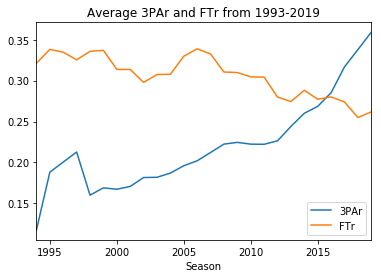

In [399]:
Threes = df.groupby('Season').mean()[['3PAr','FTr']].plot(kind='line',title='Average 3PAr and FTr from 1993-2019',legend=True)

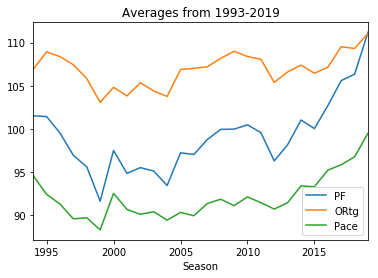

In [404]:
Points = df.groupby('Season').mean()[['PF','ORtg','Pace']].plot(kind='line',title='Averages from 1993-2019',legend=True)

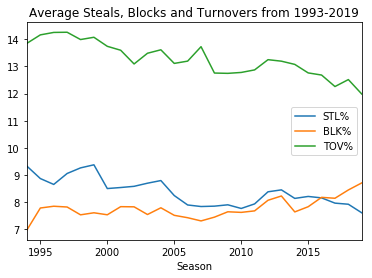

In [405]:
stlblk = df.groupby('Season').mean()[['STL%','BLK%','TOV%']].plot(kind='line',title='Average Steals, Blocks and Turnovers from 1993-2019',legend=True)

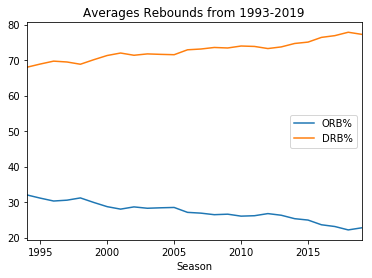

In [417]:
Rebounds = df.groupby('Season').mean()[['ORB%','DRB%']].plot(kind='line',title='Averages Rebounds from 1993-2019',legend=True)

In [412]:
fig = Threes.get_figure()
fig.savefig('threes.png')

In [413]:
fig = Points.get_figure()
fig.savefig('points.png')

In [414]:
fig = stlblk.get_figure()
fig.savefig('sbt.png')

In [418]:
fig = Rebounds.get_figure()
fig.savefig('boards.png')

In [445]:
war = df[df['Season'] == 2018]
war = war[war['Team'] == 'GSW']
war = war.set_index('G')

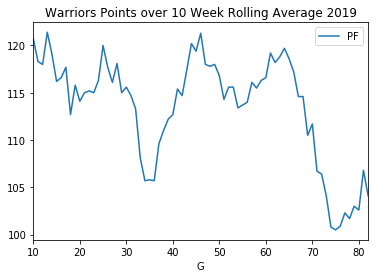

In [446]:
war = pd.Series(war['PF']).rolling(window=10).mean().iloc[10-1:].plot(kind='line', title = 'Warriors Points over 10 Week Rolling Average 2019', legend=True)

In [447]:
fig = war.get_figure()
fig.savefig('war.png')

In [451]:
rand_pred = np.random.randint(2, size=len(train))
rand_pred_test = np.random.randint(2, size=len(test))

In [450]:
np.mean(abs(rand_pred-train_y))

0.4972716867630227

In [452]:
np.mean(abs(rand_pred_test-test_y))

0.49596323438082224

In [457]:
basic_pred = [0] * len(test)

In [458]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, basic_pred)

0.49447273630604893

In [467]:
pf_diff = train1['PF'] - train1['PA']

In [504]:
difs = []
for i in ['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA']:
    opp = 'Oppo_' + i
    add = train1[i].astype(float) - train1[opp].astype(float)
    difs.append(add)

In [522]:
difs = []
for i in ['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA']:
    opp = 'Oppo_' + i
    add = valid1[i].astype(float) - valid1[opp].astype(float)
    difs.append(add)

In [524]:
difs = []
for i in ['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA']:
    opp = 'Oppo_' + i
    add = test1[i].astype(float) - test1[opp].astype(float)
    difs.append(add)

In [523]:
valid_difs = pd.DataFrame(difs).transpose()

In [525]:
test_difs = pd.DataFrame(difs).transpose()

In [508]:
train_difs = pd.DataFrame(difs).transpose()

In [521]:
test1.columns = ['G', 'Season', 'Date', 'Team', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg',
       'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%',
       'Opp_FT/FGA', 'Oppo_W/L', 'Oppo_PF', 'Oppo_PA', 'Oppo_ORtg', 'Oppo_DRtg',
       'Oppo_Pace', 'Oppo_FTr', 'Oppo_3PAr', 'Oppo_TS%', 'Oppo_TRB%', 'Oppo_AST%',
       'Oppo_STL%', 'Oppo_BLK%', 'Oppo_eFG%', 'Oppo_TOV%', 'Oppo_ORB%',
       'Oppo_FT/FGA', 'Oppo_Opp_eFG%', 'Oppo_Opp_TOV%', 'Oppo_DRB%',
       'Oppo_Opp_FT/FGA', 'Win']

In [551]:
test_difs.columns = ['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%', 'Opp_FT/FGA', 'Away']

In [526]:
train_difs['Away'] = train1['Away']
valid_difs['Away'] = valid1['Away']
test_difs['Away'] = test1['Away']

In [538]:
lm = linear_model.LogisticRegression(C=1)
lm.fit(train_difs[['W/L','PF', 'Away','DRB%', 'ORtg']], train_y)

C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [543]:
preds = lm.predict(valid_difs[['W/L','PF', 'Away','DRB%', 'ORtg']])

In [544]:
np.mean(abs(preds - valid_y))

0.3426086956521739

In [535]:
for i in [0.001,0.01,0.1,1,10,100,]:
    lm = linear_model.LogisticRegression(C=i)
    lm.fit(train_difs, train_y)
    preds = lm.predict(valid_difs)
    acc = 1 - np.mean(abs(preds - valid_y))
    print('C = ' + str(i) + 'validaction accuracy: ' + str(acc))

C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 0.001validaction accuracy: 0.6701863354037267


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 0.01validaction accuracy: 0.6732919254658385


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 0.1validaction accuracy: 0.6715527950310559


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 1validaction accuracy: 0.6705590062111801


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 10validaction accuracy: 0.670807453416149


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 100validaction accuracy: 0.6710559006211181


In [570]:
lm = linear_model.LogisticRegression(C=0.01)
lm.fit(train_difs, train_y)
preds = lm.predict(test_difs)
acc = 1 - np.mean(abs(preds - test_y))
acc

C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6604148552974786

In [569]:
for i in [0.001,0.01,0.1,1,10,100,]:
    lm = linear_model.Ridge(i, fit_intercept = False)
    lm.fit(train_difs, train_y)
    preds = lm.predict(valid_difs)
    acc = 1 - np.mean(abs(preds - valid_y))
    print('C = ' + str(i) + 'validaction accuracy: ' + str(acc))

C = 0.001validaction accuracy: 0.4752658838883689
C = 0.01validaction accuracy: 0.47527073849091406
C = 0.1validaction accuracy: 0.4752815297577647
C = 1validaction accuracy: 0.4753002641020192
C = 10validaction accuracy: 0.4753510719687156
C = 100validaction accuracy: 0.4754915409099757


In [545]:
from sklearn.decomposition import PCA
pca = PCA(n_components=22)

In [560]:
pca.fit(X)
pca.components_[0]

array([-1.73104353e-03,  5.57595422e-01,  6.06784647e-01,  3.22461057e-01,
        3.76662397e-01,  2.26802116e-01,  6.51156622e-04,  1.11984206e-03,
        1.42614711e-03, -4.62491609e-02, -5.40365019e-02, -1.19326011e-02,
       -3.61691552e-02,  1.41789196e-03, -3.01363520e-02,  3.34123002e-02,
        6.98641656e-04,  1.66253972e-03, -3.26044487e-02, -1.18302906e-01,
        3.73721377e-04, -8.15654239e-06])

In [554]:
X = pd.concat([train_difs,valid_difs,test_difs])

In [562]:
Xpca_train = pd.DataFrame(np.matmul(train_difs, pca.components_.T))
Xpca_valid = pd.DataFrame(np.matmul(valid_difs, pca.components_.T))
Xpca_test = pd.DataFrame(np.matmul(test_difs, pca.components_.T))

In [561]:
train_difs = train_difs.astype(float)
valid_difs = valid_difs.astype(float)
test_difs = test_difs.astype(float)

In [676]:
for i in [0.001,0.01,0.1,1,10,100,]:
    for n in range(5,21,5):
        x_train = Xpca_train.iloc[:,:n]
        x_valid = Xpca_valid.iloc[:,:n]
        x_test = Xpca_test.iloc[:,:n]
        lm = linear_model.LogisticRegression(C=i, class_weight='balanced', solver = 'liblinear')
        lm.fit(x_train, train_y)
        y_valid_pred = lm.predict(x_valid)
        acc = 1 - np.mean(abs(y_valid_pred - valid_y))
        print('C = ' + str(i) + ' n  = ' + str(n) + ' validaction accuracy: ' + str(acc))

C = 0.001 n  = 5 validaction accuracy: 0.6426086956521739
C = 0.001 n  = 10 validaction accuracy: 0.6468322981366459
C = 0.001 n  = 15 validaction accuracy: 0.6443478260869565
C = 0.001 n  = 20 validaction accuracy: 0.6483229813664596
C = 0.01 n  = 5 validaction accuracy: 0.6424844720496894
C = 0.01 n  = 10 validaction accuracy: 0.6467080745341616
C = 0.01 n  = 15 validaction accuracy: 0.6445962732919255
C = 0.01 n  = 20 validaction accuracy: 0.6483229813664596
C = 0.1 n  = 5 validaction accuracy: 0.6424844720496894
C = 0.1 n  = 10 validaction accuracy: 0.6472049689440994
C = 0.1 n  = 15 validaction accuracy: 0.6445962732919255
C = 0.1 n  = 20 validaction accuracy: 0.6483229813664596
C = 1 n  = 5 validaction accuracy: 0.642360248447205
C = 1 n  = 10 validaction accuracy: 0.6472049689440994
C = 1 n  = 15 validaction accuracy: 0.6445962732919255
C = 1 n  = 20 validaction accuracy: 0.6480745341614906
C = 10 n  = 5 validaction accuracy: 0.6427329192546584
C = 10 n  = 10 validaction accurac

In [610]:
def last_game(data):
    team_data = df.loc[lambda x: (x.Team == data.Team) & (x.Season == data.Season) & (x.G == data.G-1)]
    opp_G = df.loc[lambda x: (x.Team == data.Opp) & (x.Season == data.Season) & (x.Date == data.Date)].G.values[0]
    opp_data = df.loc[lambda x: (x.Team == data.Opp) & (x.Season == data.Season) & (x.G == opp_G - 1)]
    team_dif = datetime.strptime(data.Date, '%Y-%m-%d') - datetime.strptime(team_data.Date.values[0], '%Y-%m-%d')
    opp_dif = datetime.strptime(data.Date, '%Y-%m-%d') - datetime.strptime(opp_data.Date.values[0], '%Y-%m-%d')
    return [team_dif.days, opp_dif.days]

In [602]:
last_game(train.iloc[0])

2

In [584]:
from datetime import datetime

In [609]:
data = train.iloc[0]
df.loc[lambda x: (x.Team == data.Opp) & (x.Season == data.Season) & (x.Date == data.Date)].G

71

In [611]:
times = []
for i in range(len(train)):
    times.append(last_game(train.iloc[i]))

In [614]:
times_v = []
for i in range(len(valid)):
    times_v.append(last_game(valid.iloc[i]))
times_t = []
for i in range(len(test)):
    times_t.append(last_game(test.iloc[i]))

In [612]:
time_difs = [x[0] - x[1] for x in times]

In [616]:
time_difs_v = [x[0] - x[1] for x in times_v]
time_difs_t = [x[0] - x[1] for x in times_t]

In [617]:
train_difs['days'] = time_difs
valid_difs['days'] = time_difs_v
test_difs['days'] = time_difs_t

In [664]:
train_difs.columns

Index(['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp_eFG%',
       'Opp_TOV%', 'DRB%', 'Opp_FT/FGA', 'Away', 'days'],
      dtype='object')

In [674]:
for i in ['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp_eFG%',
       'Opp_TOV%', 'DRB%', 'Opp_FT/FGA', 'Away', 'days']:
    lm = linear_model.LogisticRegression(C=0.01)
    lm.fit(train_difs.drop(['eFG%','FT/FGA','BLK%','Opp_eFG%', i], axis=1), train_y)
    preds = lm.predict(valid_difs.drop(['eFG%','FT/FGA','BLK%','Opp_eFG%', i], axis=1))
    acc = 1 - np.mean(abs(preds - valid_y))
    print('C = ' + str(i) + 'validaction accuracy: ' + str(acc) + str(i))

C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = W/Lvalidaction accuracy: 0.6724223602484471W/L


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = PFvalidaction accuracy: 0.6746583850931678PF


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = PAvalidaction accuracy: 0.6746583850931678PA


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = ORtgvalidaction accuracy: 0.6750310559006212ORtg


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = DRtgvalidaction accuracy: 0.675776397515528DRtg


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = Pacevalidaction accuracy: 0.675776397515528Pace


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = FTrvalidaction accuracy: 0.6750310559006212FTr


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 3PArvalidaction accuracy: 0.67366459627329193PAr


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = TS%validaction accuracy: 0.675776397515528TS%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = TRB%validaction accuracy: 0.6742857142857143TRB%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = AST%validaction accuracy: 0.6737888198757764AST%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = STL%validaction accuracy: 0.6727950310559005STL%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = BLK%validaction accuracy: 0.675776397515528BLK%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = eFG%validaction accuracy: 0.675776397515528eFG%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = TOV%validaction accuracy: 0.6754037267080746TOV%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = ORB%validaction accuracy: 0.6746583850931678ORB%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = FT/FGAvalidaction accuracy: 0.675776397515528FT/FGA


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = Opp_eFG%validaction accuracy: 0.675776397515528Opp_eFG%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = Opp_TOV%validaction accuracy: 0.6737888198757764Opp_TOV%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = DRB%validaction accuracy: 0.6740372670807453DRB%


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = Opp_FT/FGAvalidaction accuracy: 0.6754037267080746Opp_FT/FGA


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = Awayvalidaction accuracy: 0.6463354037267081Away


C:\Users\brand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = daysvalidaction accuracy: 0.6744099378881987days


In [673]:
preds = lm.predict(test_difs.drop(['eFG%','FT/FGA','BLK%', i], axis=1))
acc = 1 - np.mean(abs(preds - test_y))
acc

0.6610358961619675

In [619]:
all_difs = pd.concat([train_difs,valid_difs,test_difs])

In [622]:
seasons = pd.concat([train['Season'], valid['Season'],test['Season']])
all_difs['Season'] = seasons
all_difs.head()

,W/L,PF,PA,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,...,TOV%,ORB%,FT/FGA,Opp_eFG%,Opp_TOV%,DRB%,Opp_FT/FGA,Away,days,Season
0,0.0,9.1,8.3,7.22,6.02,1.89,0.0768,-0.0353,0.0369,2.03,...,-0.50,1.08,0.0503,0.0403,-0.23,4.12,0.0148,1.0,1,2005
1,-0.1,-12.7,-5.9,-9.71,-1.74,-1.45,0.0445,-0.0417,-0.0350,1.71,...,2.47,0.37,0.0246,0.0376,4.83,5.89,0.0184,0.0,1,2003
2,-0.5,-3.6,7.4,-9.78,2.62,2.96,-0.1012,0.0497,-0.0610,-7.26,...,-2.86,-7.81,-0.0665,0.0554,2.87,2.53,0.0640,1.0,0,2010
3,0.0,8.0,0.6,4.28,-3.92,3.68,-0.0048,0.0245,0.0294,0.10,...,-0.31,-0.24,-0.0174,-0.0287,0.39,1.22,0.0571,1.0,0,1997
4,-0.1,1.9,-7.4,-0.41,-9.94,3.17,0.0124,0.0654,0.0179,0.54,...,0.94,-2.75,-0.0052,-0.0281,3.16,2.10,-0.0253,0.0,1,2019


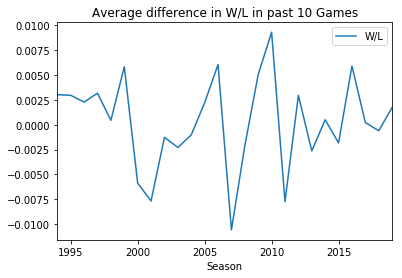

In [633]:
wldif = all_difs.groupby('Season').mean()[['W/L']].plot(kind='line',title = 'Average difference in W/L in past 10 Games')

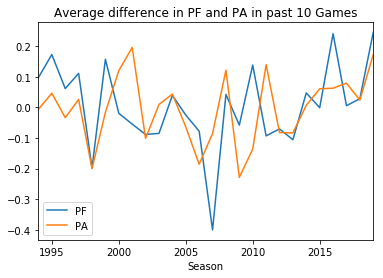

In [635]:
pfpadif = all_difs.groupby('Season').mean()[['PF','PA']].plot(kind='line',title = 'Average difference in PF and PA in past 10 Games')

In [636]:
fig = wldif.get_figure()
fig.savefig('wldif.png')

In [637]:
fig = pfpadif.get_figure()
fig.savefig('pfpadif.png')

In [638]:
valid_difs.columns

Index(['W/L', 'PF', 'PA', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp_eFG%',
       'Opp_TOV%', 'DRB%', 'Opp_FT/FGA', 'Away', 'days'],
      dtype='object')

In [641]:
from sklearn.svm import SVC

In [642]:
svc = SVC(C=1.0)
svc.fit(train_difs, train_y)

C:\Users\brand\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [644]:
preds = svc.predict(valid_difs)
1 - np.mean(abs(preds - valid_y))

0.6118012422360248

In [645]:
from sklearn.decomposition import PCA
pca = PCA()

In [651]:
X_tr = train1.drop(['G','Season','Date','Team','Opp','Win'], axis = 1)
X_va = valid1.drop(['G','Season','Date','Team','Opp','Win'], axis = 1)
X_te = test1.drop(['G','Season','Date','Team','Opp','Win'], axis = 1)

In [652]:
X = pd.concat([X_tr, X_va, X_te])

In [653]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [654]:
pca.components_[0]

array([-1.93424537e-05,  7.79888025e-05,  4.16837848e-01,  4.14268723e-01,
        2.03167168e-01,  2.00770978e-01,  2.08541299e-01, -7.66965485e-04,
        3.24852786e-03,  1.15455128e-03, -8.87007332e-03, -4.39659734e-02,
       -2.27172509e-02,  4.78688424e-03,  1.30883363e-03, -3.87797968e-02,
       -1.19755043e-01, -3.85287514e-04,  1.28465795e-03, -3.92148490e-02,
        1.00057986e-01, -5.24958341e-04,  9.12915255e-05,  4.16592676e-01,
        4.13644491e-01,  2.03210157e-01,  2.00387453e-01,  2.08298583e-01,
       -7.60743882e-04,  3.25195669e-03,  1.15575256e-03, -8.73889244e-03,
       -4.38606788e-02, -2.27926811e-02,  4.79452636e-03,  1.30956098e-03,
       -3.87581015e-02, -1.20002899e-01, -3.80957068e-04,  1.28320801e-03,
       -3.93424951e-02,  1.00459661e-01, -5.27943554e-04])

In [657]:
Xpca_train = pd.DataFrame(np.matmul(X_tr, pca.components_.T))
Xpca_valid = pd.DataFrame(np.matmul(X_va, pca.components_.T))
Xpca_test = pd.DataFrame(np.matmul(X_te, pca.components_.T))

In [656]:
X_tr = X_tr.astype(float)
X_va = X_va.astype(float)
X_te = X_te.astype(float)

In [659]:
for i in [0.001,0.01,0.1,1,10,100,]:
    for n in range(5,21,5):
        x_train = Xpca_train.iloc[:,:n]
        x_valid = Xpca_valid.iloc[:,:n]
        x_test = Xpca_test.iloc[:,:n]
        lm = linear_model.LogisticRegression(C=i, class_weight='balanced', solver = 'liblinear')
        lm.fit(x_train, train_y)
        y_valid_pred = lm.predict(x_valid)
        acc = 1 - np.mean(abs(y_valid_pred - valid_y))
        print('C = ' + str(i) + ' n  = ' + str(n) + ' validaction accuracy: ' + str(acc))

C = 0.001 n  = 5 validaction accuracy: 0.6424844720496894
C = 0.001 n  = 10 validaction accuracy: 0.6467080745341616
C = 0.001 n  = 15 validaction accuracy: 0.6442236024844721
C = 0.001 n  = 20 validaction accuracy: 0.6481987577639752
C = 0.01 n  = 5 validaction accuracy: 0.6424844720496894
C = 0.01 n  = 10 validaction accuracy: 0.6468322981366459
C = 0.01 n  = 15 validaction accuracy: 0.6443478260869565
C = 0.01 n  = 20 validaction accuracy: 0.6481987577639752
C = 0.1 n  = 5 validaction accuracy: 0.6427329192546584
C = 0.1 n  = 10 validaction accuracy: 0.6468322981366459
C = 0.1 n  = 15 validaction accuracy: 0.6442236024844721
C = 0.1 n  = 20 validaction accuracy: 0.6481987577639752
C = 1 n  = 5 validaction accuracy: 0.6437267080745341
C = 1 n  = 10 validaction accuracy: 0.6468322981366459
C = 1 n  = 15 validaction accuracy: 0.6442236024844721
C = 1 n  = 20 validaction accuracy: 0.6480745341614906
C = 10 n  = 5 validaction accuracy: 0.6436024844720497
C = 10 n  = 10 validaction accura

In [675]:
train1.columns

Index(['G', 'Season', 'Date', 'Team', 'Away', 'Opp', 'W/L', 'PF', 'PA', 'ORtg',
       'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp_eFG%', 'Opp_TOV%', 'DRB%',
       'Opp_FT/FGA', 'Oppo_W/L', 'Oppo_PF', 'Oppo_PA', 'Oppo_ORtg',
       'Oppo_DRtg', 'Oppo_Pace', 'Oppo_FTr', 'Oppo_3PAr', 'Oppo_TS%',
       'Oppo_TRB%', 'Oppo_AST%', 'Oppo_STL%', 'Oppo_BLK%', 'Oppo_eFG%',
       'Oppo_TOV%', 'Oppo_ORB%', 'Oppo_FT/FGA', 'Oppo_Opp_eFG%',
       'Oppo_Opp_TOV%', 'Oppo_DRB%', 'Oppo_Opp_FT/FGA', 'Win'],
      dtype='object')